In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from theano import tensor as tt

warnings.filterwarnings('ignore', category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
az.rcParams['stats.hdi_prob'] = 0.89  # set credible interval for entire notebook
az.rcParams['stats.information_criterion'] = 'waic'  # set information criterion to use in `compare`
az.rcParams['stats.ic_scale'] = 'deviance'    # set information criterion scale
np.random.seed(0)

#### Code 16.4

In [3]:
df = pd.read_csv('Data/Boxes.csv', delimiter=';')
df.describe()

,y,gender,age,majority_first,culture
count,629.000000,629.000000,629.000000,629.000000,629.000000
mean,2.120827,1.505564,8.030207,0.484897,3.751987
std,0.727986,0.500367,2.497906,0.500170,1.960319
min,1.000000,1.000000,4.000000,0.000000,1.000000
25%,2.000000,1.000000,6.000000,0.000000,3.000000
50%,2.000000,2.000000,8.000000,0.000000,3.000000
75%,3.000000,2.000000,10.000000,1.000000,5.000000
max,3.000000,2.000000,14.000000,1.000000,8.000000


#### Code 16.5

In [4]:
df['y'].value_counts(normalize=True, sort=False)

1    0.211447
2    0.456280
3    0.332273
Name: y, dtype: float64

#### Code 16.6

In [5]:
N = 30  # number of children

# half are random
# sample from 1, 2, 3 at random for each
y1 = np.random.randint(low=1, high=4, size=N//2)

y2 = np.full(shape=N // 2, fill_value=2)

y = np.random.permutation(np.hstack((y1, y2)))
np.sum(y==2) / N

0.6333333333333333

#### Code 16.7

In [6]:
def StrategyMixture(p, majority_first):

    def logp(y):
        phi = [None] * 5
        
        # Probability of data
        phi[0] = tt.switch( tt.eq(y, 2), 1, 0)
        phi[1] = tt.switch( tt.eq(y, 3), 1, 0)
        phi[2] = tt.switch( tt.eq(y, 1), 1, 0)
        phi[3] = tt.ones_like(y) * 1/3
        phi[4] = tt.switch( tt.eq(majority_first, 1),
                         tt.switch( tt.eq(y, 2), 1, 0),
                         tt.switch( tt.eq(y, 3), 1, 0)
                        )    
        
        # Compute log ( p_s * Pr(y_i|s) )
        for i in range(5):
            phi[i] = tt.log(phi[i]) + tt.log(p[i])
            
        # Compute average log-probability of y_i
        return tt.sum(pm.math.logsumexp(phi, axis=0))

    return logp

with pm.Model() as m16_2:
    # prior
    p = pm.Dirichlet('p', np.array([4, 4, 4, 4, 4]))
    
    # likelihood
    y = pm.DensityDist('y', StrategyMixture(p, df['majority_first']), observed=df['y'])

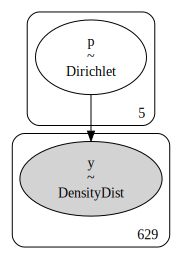

In [7]:
pm.model_to_graphviz(m16_2)

#### Code 16.8

In [8]:
with m16_2:
    m16_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


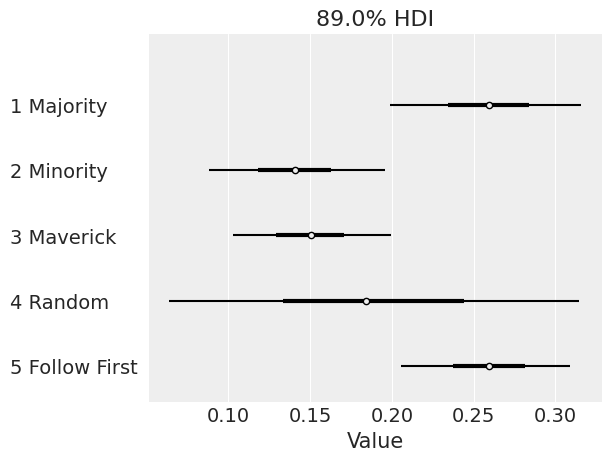

In [9]:
az.plot_forest(m16_2_trace, combined=True, colors='black')

ax = plt.gca()
ax.set_yticklabels([f'5 Follow First', '4 Random', '3 Maverick', '2 Minority', '1 Majority'], ha='left')
ax.get_yaxis().set_tick_params(pad=100)
plt.xlabel('Value');

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz  0.9.0
numpy  1.18.2
pandas 1.0.3
pymc3  3.9.2
last updated: Fri Sep 11 2020 

CPython 3.8.2
IPython 7.13.0
watermark 2.0.2
